In [1]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystan
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import scale

from rethinking.utils import hpdi

np.set_printoptions(precision=3)

In [2]:
DATA_FOLDER = '../data'

HOWELL_PATH = os.path.join(DATA_FOLDER, 'howell1.csv')

In [3]:
howell_full = pd.read_csv(HOWELL_PATH)
howell = howell_full[howell_full.age >= 18]
howell.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
howell.describe()

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [5]:
height = howell.loc[howell.age >= 18, 'height']

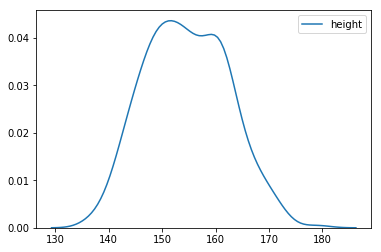

In [6]:
sns.kdeplot(height)

$$
\begin{align}
    h_i &\sim Normal(\mu, \sigma) \\
    \mu &\sim Normal(178, 20) \\
    \sigma &\sim Uniform(0, 50)
\end{align}
$$

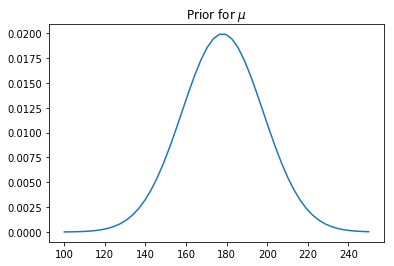

In [7]:
x = np.linspace(start=100, stop=250, num=50)
y = stats.norm(178, 20).pdf(x)
plt.plot(x, y)
plt.title('Prior for $\mu$')
plt.show()

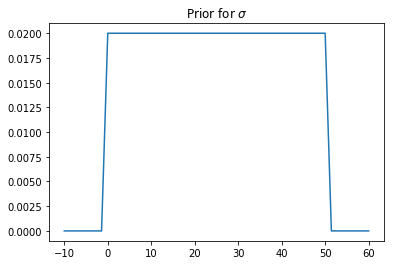

In [8]:
x = np.linspace(start=-10, stop=60, num=50)
y = stats.uniform(0, 50).pdf(x)
plt.plot(x, y)
plt.title('Prior for $\sigma$')
plt.show()

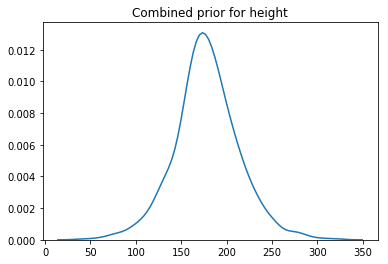

In [9]:
x = np.linspace(start=100, stop=1000, num=100)
sample_mu = np.random.normal(loc=178, scale=20, size=1000)
sample_sigma = np.random.uniform(low=0, high=50, size=1000)
prior_h = np.random.normal(loc=sample_mu, scale=sample_sigma, size=1000)
sns.kdeplot(prior_h)
plt.title('Combined prior for height')
plt.show()

In [10]:
height_code = """
data {
    int<lower=0> N;                     // number of observations
    real<lower=0, upper=200> height[N];
}
parameters {
    real<lower=0, upper=200> mu;
    real<lower=0, upper=50> sigma;
}
model {
    sigma ~ uniform(0, 50);
    mu ~ normal(178, 20);
    height ~ normal(mu, sigma);
}
"""
sm = pystan.StanModel(model_code=height_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8d31e40f641b9b8cc45d2133fda0c734 NOW.


In [11]:
height_data = dict(
    N=len(height),
    height=height
)

In [12]:
fit = sm.sampling(data=height_data, iter=1000, chains=4)
fit

Inference for Stan model: anon_model_8d31e40f641b9b8cc45d2133fda0c734.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu    154.59  9.2e-3   0.39 153.86 154.34 154.59 154.85 155.36   1803    1.0
sigma   7.77  6.9e-3   0.29    7.2   7.57   7.77   7.95   8.35   1769    1.0
lp__  -892.1    0.03   0.96 -894.7 -892.4 -891.8 -891.4 -891.2   1004    1.0

Samples were drawn using NUTS at Sat Dec 23 20:13:20 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

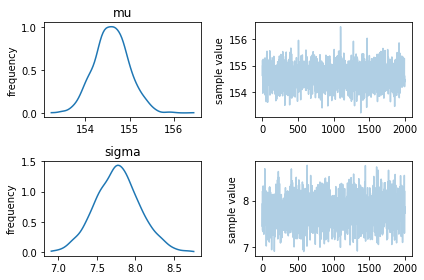

In [13]:
fit.plot()
plt.tight_layout()
plt.show()

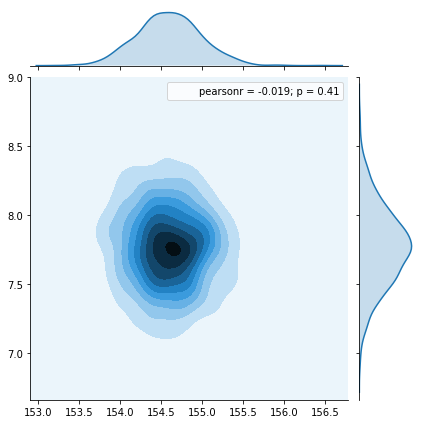

In [14]:
posterior = fit.extract(permuted=True)
sns.jointplot(x='mu', y='sigma', data=posterior, kind='kde')

# Sampling from the posterior

In [15]:
sample_rows = np.random.choice(a=range(len(posterior['lp__'])), replace=True, size=10000)
sample_mu = posterior['mu'][sample_rows]
sample_sigma = posterior['sigma'][sample_rows]

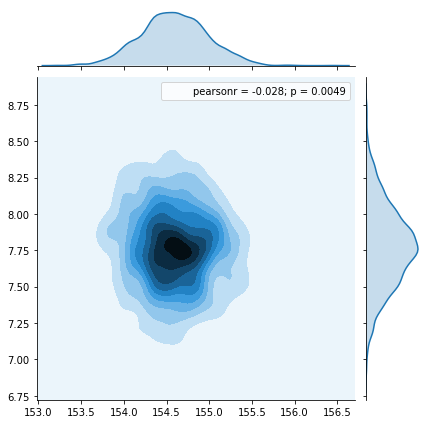

In [16]:
sns.jointplot(x=sample_mu, y=sample_sigma, kind='kde')

In [17]:
hpdi_mu = hpdi(samples=sample_mu, prob=.95)
hpdi_sigma = hpdi(samples=sample_sigma, prob=.95)
print(f'HPDI mu: {hpdi_mu}\nHPDI sigma: {hpdi_sigma}')

HPDI mu: (153.85508126155761, 155.36900198730342)
HPDI sigma: (7.2038780580301225, 8.358541996923897)


# Adding a predictor

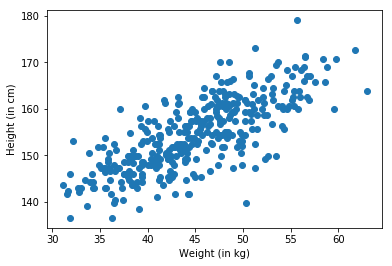

In [18]:
plt.scatter(x='weight', y='height', data=howell)
plt.xlabel('Weight (in kg)')
plt.ylabel('Height (in cm)')
plt.show()

$$
\begin{align}
    h_i &\sim Normal(\mu_i, \sigma) \\
    \mu_i &= \alpha + \beta x_i \\
    \alpha &\sim Normal(178, 100) \\
    \beta &\sim Normal(0, 10) \\
    \sigma &\sim Uniform(0, 50)
\end{align}
$$

In [19]:
predictor_code = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] h;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    //sigma ~ uniform(0, 50);
    alpha ~ normal(178, 100);
    beta ~ normal(0, 10);
    h ~ normal(alpha + beta * x, sigma);
}
"""
sm2 = pystan.StanModel(model_code=predictor_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ca771d17a2d5b24bd8df39a9208e428a NOW.


We found that the Uniform(0, 50) prior for $\sigma$ as suggest by the author (McElreath) causes an extremely low effective sample size (ESS). We commented out the prior to fix the issue. Further analyses should be conducted to understand why this is happening since:
* The posterior distribution of $\sigma$ is within the interval (0, 50)
* The default prior for sigma, when not manually specified by the user, is a uniform prior bounded between $0$ and $\inf$. This is much larger than the interval (0, 50)

In [20]:
predictor_data = dict(
    N=len(howell.height),
    x=howell.weight,
    h=howell.height)

In [21]:
fit2 = sm2.sampling(data=predictor_data, iter=4000)
fit2

Inference for Stan model: anon_model_ca771d17a2d5b24bd8df39a9208e428a.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha 113.99    0.04   1.86  110.3 112.73 113.97 115.26 117.63   2628    1.0
beta     0.9  7.9e-4   0.04   0.82   0.87    0.9   0.93   0.98   2669    1.0
sigma    5.1  3.3e-3   0.19   4.74   4.97    5.1   5.23   5.48   3311    1.0
lp__  -747.6    0.02    1.2 -750.7 -748.1 -747.2 -746.7 -746.2   2749    1.0

Samples were drawn using NUTS at Sat Dec 23 20:14:18 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [22]:
samples2 = fit2.extract(permuted=True)
s = pd.DataFrame(samples2)
s.describe()

,alpha,beta,sigma,lp__
count,8000.000000,8000.000000,8000.000000,8000.000000
mean,113.986570,0.902697,5.100479,-747.606638
std,1.862825,0.040904,0.190827,1.200920
min,106.104480,0.740874,4.456187,-756.314071
25%,112.729045,0.874815,4.965951,-748.163758
50%,113.969015,0.902921,5.096800,-747.284885
75%,115.257803,0.930518,5.225898,-746.717925
max,121.329830,1.063224,5.819914,-746.132730


The program doesn't seem to contain bugs. Samples from the priors looks okay.

In [23]:
np.corrcoef(s.drop('lp__', axis='columns').T
            .as_matrix())

array([[ 1.   , -0.989,  0.02 ],
       [-0.989,  1.   , -0.018],
       [ 0.02 , -0.018,  1.   ]])

The correlation matrix shows an extremely high negative correlation between $\alpha$ and $\beta$. This can be fixed centering the predictors.

# Centering

In [24]:
howell['weight_c'] = scale(X=howell['weight'], with_mean=True, with_std=False)

/home/gianluca/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


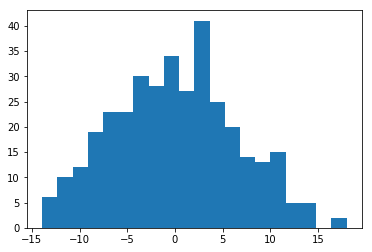

In [25]:
plt.hist(howell.weight_c, bins=20)
plt.show()

In [26]:
predictor_data = dict(
    N=len(howell.height),
    x=howell.weight_c,
    h=howell.height)

fit3 = sm2.sampling(data=predictor_data, iter=4000)
fit3

Inference for Stan model: anon_model_ca771d17a2d5b24bd8df39a9208e428a.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  154.6  3.0e-3   0.27 154.06 154.41  154.6 154.78 155.13   8000    1.0
beta    0.91  4.7e-4   0.04   0.82   0.88    0.9   0.93   0.99   8000    1.0
sigma    5.1  2.1e-3   0.19   4.75   4.97   5.09   5.22    5.5   8000    1.0
lp__  -747.4    0.02   1.22 -750.4 -747.9 -747.1 -746.5 -746.0   4478    1.0

Samples were drawn using NUTS at Sat Dec 23 20:14:19 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [27]:
samples3 = fit3.extract(permuted=True)
s3 = pd.DataFrame(samples3)

np.corrcoef(s3.drop('lp__', axis='columns').T
            .as_matrix())

array([[ 1.   , -0.006,  0.022],
       [-0.006,  1.   , -0.007],
       [ 0.022, -0.007,  1.   ]])

Note that the posterior mean and standard deviation for $\beta$ and $\sigma$ is the same as the one in the model without centering the predictors. The effective sample size though is much larger when the model's predictors are centered. Of course, centering the predictors affects the intercept ($\alpha$).

# Plotting prosterior inference against the data

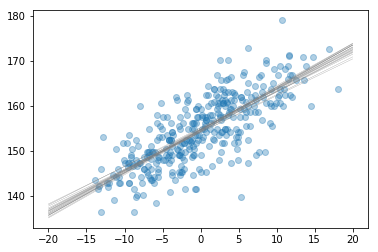

In [28]:
plt.scatter(x='weight_c', y='height', data=howell, alpha=.35)
x = np.array([-20, 20])
for i in np.random.choice(range(8000), size=20, replace=False):
    f = lambda x: s3.loc[i, 'alpha'] + s3.loc[i, 'beta'] * x
    plt.plot(x, f(x), linewidth=0.25, c='grey')
plt.show()

# Polynomial regression

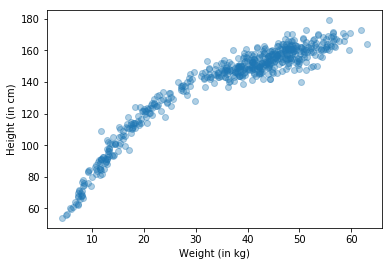

In [29]:
plt.scatter(x='weight', y='height', data=howell_full, alpha=.35)
plt.xlabel('Weight (in kg)')
plt.ylabel('Height (in cm)')
plt.show()

In [30]:
howell_full['weight_s'] = scale(
    X=howell_full.weight, with_mean=True, with_std=True)

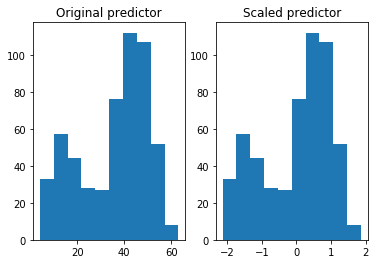

In [31]:
plt.subplot(121)
plt.hist(howell_full.weight)
plt.title('Original predictor')

plt.subplot(122)
plt.hist(howell_full.weight_s)
plt.title('Scaled predictor')
plt.show()

In [32]:
poly_code = """
data {
    int<lower=0> N;                  // n observations
    int<lower=0> M;                  // n features
    vector[N] weight;
    vector[N] weight_2;              // weight^2
    vector[N] height;
}
parameters {
    real alpha;
    real beta[M];
    real<lower=0> sigma;
}
model {
    alpha ~ normal(178, 100);
    beta ~ normal(0, 10);
    height ~ normal(alpha + beta[1] * weight + beta[2] * weight_2, sigma);
}"""

sm3 = pystan.StanModel(model_code=poly_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3b98578e029231942443904b57dcdcb5 NOW.


In [33]:
poly_data = dict(
    N=len(howell_full.height),
    M=2,
    weight=howell_full.weight_s,
    weight_2=np.power(howell_full.weight_s, 2),
    height=howell_full.height)

fit4 = sm3.sampling(data=poly_data, iter=4000)
fit4

Inference for Stan model: anon_model_3b98578e029231942443904b57dcdcb5.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   146.66  5.7e-3   0.38 145.92  146.4 146.66 146.91  147.4   4400    1.0
beta[0]  21.38  4.0e-3   0.29  20.81  21.18  21.38  21.58  21.96   5223    1.0
beta[1]   -8.4  4.3e-3   0.28  -8.96  -8.59  -8.39   -8.2  -7.85   4473    1.0
sigma     5.78  2.2e-3   0.18   5.45   5.65   5.77   5.89   6.13   6655    1.0
lp__     -1226    0.02   1.43  -1230  -1227  -1226  -1225  -1224   3521    1.0

Samples were drawn using NUTS at Sat Dec 23 20:15:13 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

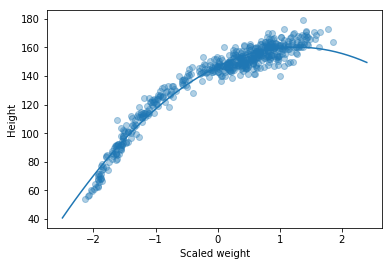

In [34]:
x = np.arange(start=-2.5, stop=2.5, step=0.1)
f = np.vectorize(lambda x: 146.67 + 21.38 * x -8.41 * np.power(x, 2))
y = f(x)
plt.scatter(x='weight_s', y='height', data=howell_full, alpha=.35)
plt.plot(x, y)
plt.xlabel('Scaled weight')
plt.ylabel('Height')
plt.show()
